/var/folders/tx/k8p2xbtn0cjgvn8dh714226r0000gn/T/ipykernel_54896/418974182.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].median(), inplace=True)


Features after correlation-based removal: ['flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate', 'Drate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count', 'fin_count', 'urg_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC', 'Tot sum', 'Min', 'IAT', 'Variance']
New best parameters: hidden_size=32, num_layers=1, CV Accuracy=0.6722
New best parameters: hidden_size=32, num_layers=2, CV Accuracy=0.7261
Early stopping at epoch 53
Final Model Accuracy: 0.7536458333333333

Classification Report:

              precision    recall  f1-score   support

      Benign       0.70      0.75      0.72      6000
  BruteForce       0.52      0.58      0.55      6000
        DDoS       0.99      0.96      0.98      6000
         DoS       0.96      0.99      0.98      6000
       Mirai       1.00      1.00      1.00 

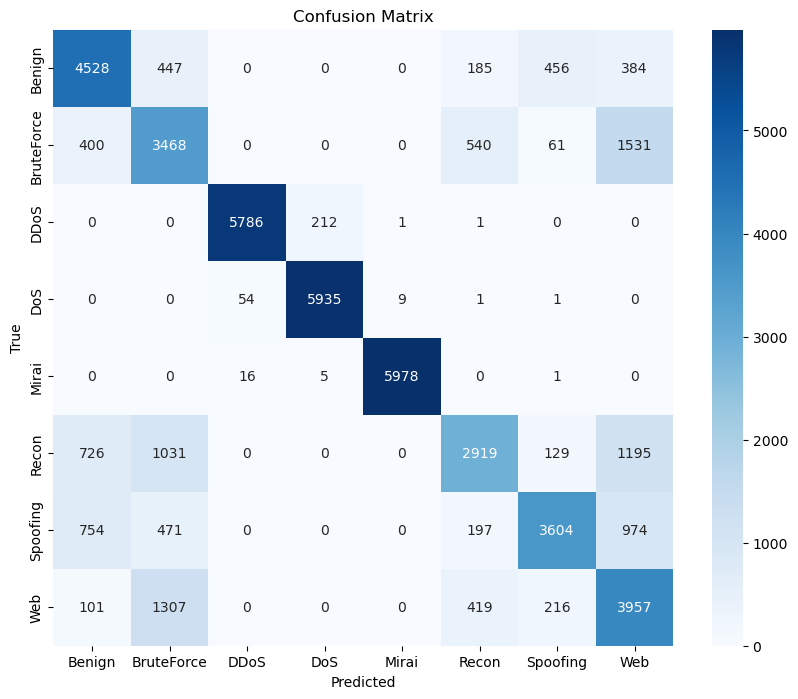

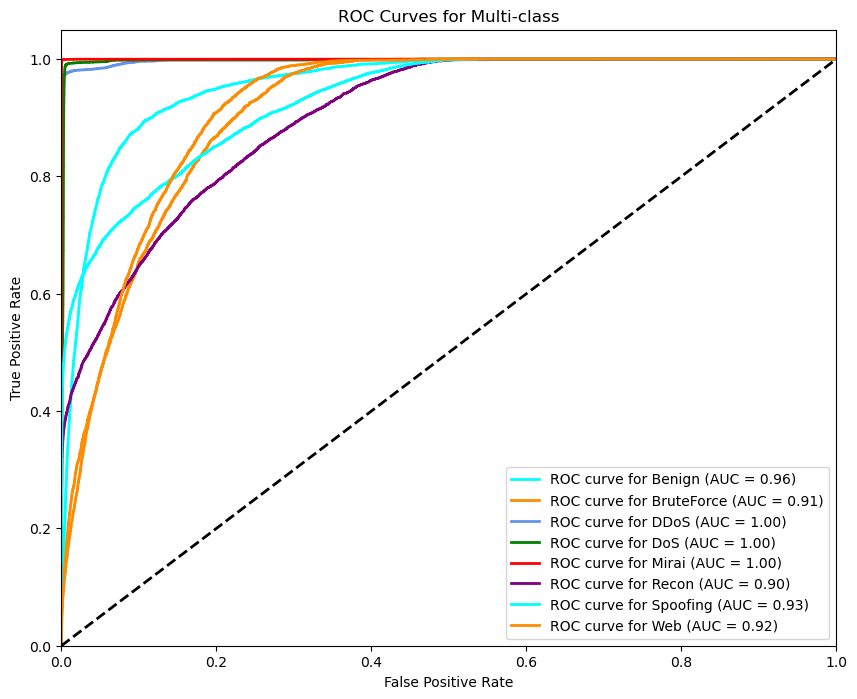

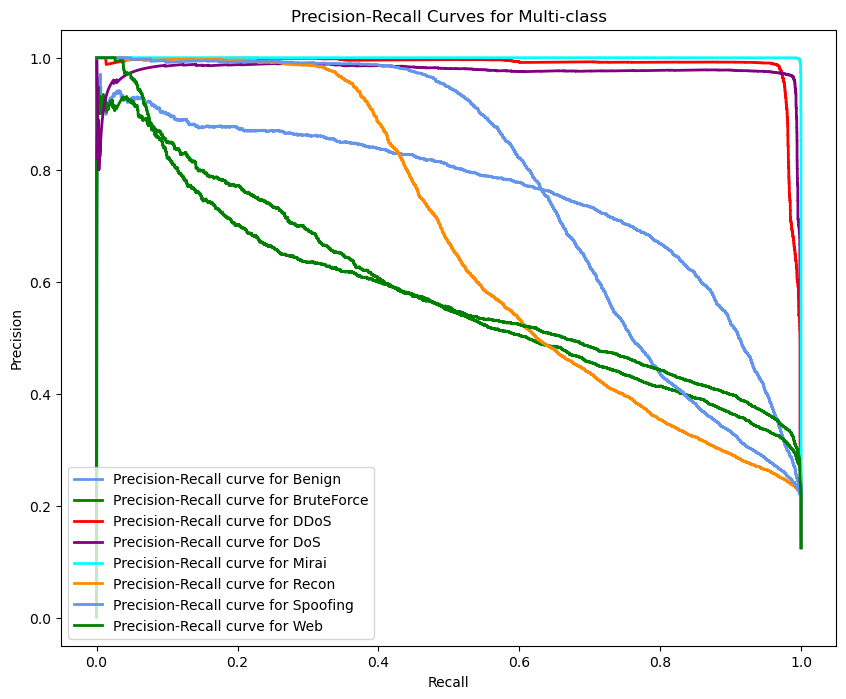

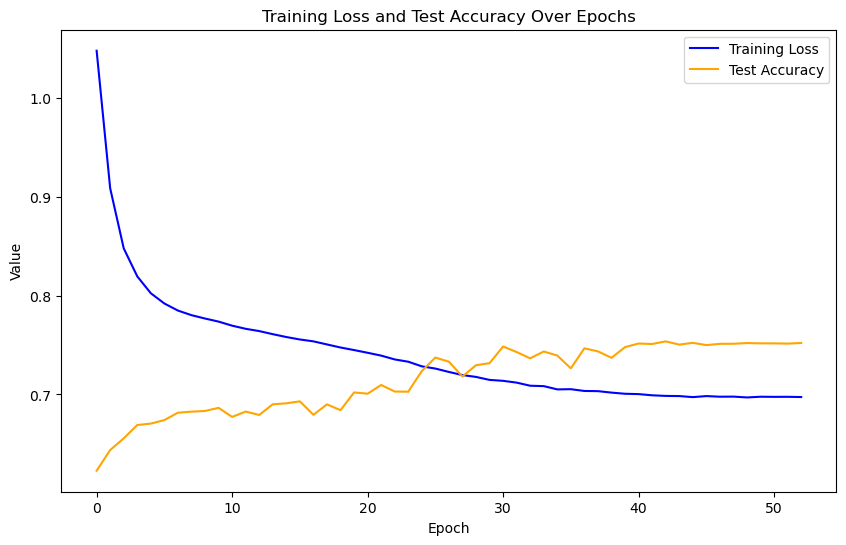

In [1]:

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Load the dataset
data = pd.read_csv('/Users/bodapati/Downloads/balanced_dataset3.csv')

# Define features and target
features = ['flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate', 'Srate', 'Drate',
            'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
            'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count', 'fin_count', 'urg_count',
            'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP',
            'ARP', 'ICMP', 'IPv', 'LLC', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT',
            'Number', 'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight']
target = 'label'

# Preprocessing
# Handle missing values
for col in features:
    if data[col].dtype in ['float64', 'int64']:
        data[col].fillna(data[col].median(), inplace=True)
    else:
        data[col].fillna(data[col].mode()[0], inplace=True)

# Feature engineering: Add interaction features
data['Rate_Duration'] = data['Rate'] / (data['Duration'] + 1e-6)
data['Header_TotSize_Ratio'] = data['Header_Length'] / (data['Tot size'] + 1e-6)
features += ['Rate_Duration', 'Header_TotSize_Ratio']

# Outlier clipping
for col in features:
    if data[col].dtype in ['float64', 'int64']:
        q1, q3 = data[col].quantile([0.25, 0.75])
        iqr = q3 - q1
        lower_bound, upper_bound = q1 - 1.5 * iqr, q3 + 1.5 * iqr
        data[col] = data[col].clip(lower_bound, upper_bound)

# Feature scaling
scaler = StandardScaler()
data[features] = scaler.fit_transform(data[features])

# Feature selection: Remove highly correlated features
corr_matrix = data[features].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
features = [f for f in features if f not in to_drop]
print(f"Features after correlation-based removal: {features}")

# Prepare features and target
X = data[features].values
y = data[target].values

# Encode target labels
le = LabelEncoder()
y = le.fit_transform(y)

# Apply SMOTE for slight imbalances
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define RNN model
class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNNClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.dropout(out[:, -1, :])  # Take the last time step
        out = self.fc(out)
        return out

# Hyperparameters
input_size = len(features)  # Number of features
hidden_size = 64
num_layers = 2
num_classes = len(np.unique(y))
batch_size = 128
num_epochs = 100
learning_rate = 1e-3
patience = 10

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train).unsqueeze(1)  # Add time step dimension (batch, 1, features)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test).unsqueeze(1)
y_test_tensor = torch.LongTensor(y_test)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Cross-validation for hyperparameter tuning
kf = KFold(n_splits=5, shuffle=True, random_state=42)
best_val_accuracy = 0
best_model_state = None

for hidden_size in [32, 64]:
    for num_layers in [1, 2]:
        val_accuracies = []
        for train_idx, val_idx in kf.split(X_train):
            X_tr, X_val = X_train[train_idx], X_train[val_idx]
            y_tr, y_val = y_train[train_idx], y_train[val_idx]
            
            X_tr_tensor = torch.FloatTensor(X_tr).unsqueeze(1)
            y_tr_tensor = torch.LongTensor(y_tr)
            X_val_tensor = torch.FloatTensor(X_val).unsqueeze(1)
            y_val_tensor = torch.LongTensor(y_val)
            
            train_ds = TensorDataset(X_tr_tensor, y_tr_tensor)
            train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
            
            model = RNNClassifier(input_size, hidden_size, num_layers, num_classes)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
            
            best_val_loss = float('inf')
            patience_counter = 0
            
            for epoch in range(num_epochs):
                model.train()
                for X_batch, y_batch in train_dl:
                    optimizer.zero_grad()
                    outputs = model(X_batch)
                    loss = criterion(outputs, y_batch)
                    loss.backward()
                    optimizer.step()
                
                scheduler.step()
                
                # Validation
                model.eval()
                with torch.no_grad():
                    val_outputs = model(X_val_tensor)
                    val_loss = criterion(val_outputs, y_val_tensor)
                    _, val_preds = torch.max(val_outputs, 1)
                    val_accuracy = accuracy_score(y_val, val_preds.numpy())
                
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if patience_counter >= patience:
                        break
            
            val_accuracies.append(val_accuracy)
        
        avg_val_accuracy = np.mean(val_accuracies)
        if avg_val_accuracy > best_val_accuracy:
            best_val_accuracy = avg_val_accuracy
            best_model_state = {'hidden_size': hidden_size, 'num_layers': num_layers}
            print(f"New best parameters: hidden_size={hidden_size}, num_layers={num_layers}, CV Accuracy={avg_val_accuracy:.4f}")

# Train final model with best parameters
model = RNNClassifier(input_size, best_model_state['hidden_size'], best_model_state['num_layers'], num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

# Training loop with loss tracking
train_losses = []
test_accuracies = []
best_test_accuracy = 0
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    train_losses.append(epoch_loss / len(train_loader))
    scheduler.step()
    
    # Test accuracy
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        _, test_preds = torch.max(test_outputs, 1)
        test_accuracy = accuracy_score(y_test, test_preds.numpy())
        test_accuracies.append(test_accuracy)
    
    if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        patience_counter = 0
        torch.save(model.state_dict(), 'rnn_model.pt')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# Load best model
model.load_state_dict(torch.load('rnn_model.pt'))
model.eval()

# Make predictions
with torch.no_grad():
    y_pred_proba = model(X_test_tensor)
    y_pred_proba = torch.softmax(y_pred_proba, dim=1).numpy()
    _, y_pred = torch.max(torch.FloatTensor(y_pred_proba), 1)

# Decode predictions
y_pred_labels = le.inverse_transform(y_pred.numpy())
y_test_labels = le.inverse_transform(y_test)

# Evaluate the model
print("Final Model Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test_labels, y_pred_labels))

# Plot 1: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Plot 2: ROC Curves for each class
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])
n_classes = len(le.classes_)
y_test_bin = np.zeros((y_test.shape[0], n_classes))
for i in range(n_classes):
    y_test_bin[:, i] = (y_test == i).astype(int)

for i, color in zip(range(n_classes), colors):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2, 
             label=f'ROC curve for {le.classes_[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multi-class')
plt.legend(loc="lower right")
plt.show()

# Plot 3: Precision-Recall Curve for each class
plt.figure(figsize=(10, 8))
for i, color in zip(range(n_classes), colors):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_proba[:, i])
    plt.plot(recall, precision, color=color, lw=2, 
             label=f'Precision-Recall curve for {le.classes_[i]}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Multi-class')
plt.legend(loc="lower left")
plt.show()

# Plot 4: Training Loss and Test Accuracy
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(test_accuracies, label='Test Accuracy', color='orange')
plt.title('Training Loss and Test Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()
